In [97]:
# %cd ../src
# %ls
# %cd ..

In [98]:
import sys
sys.path.insert(1, '..')
from utils import timeSteps2stepSize

this version supports over damped and underdamped dynamics

In [99]:
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as random
import flax
from flax import linen as nn
import optax

import time

import os
import pickle

import matplotlib.pyplot as plt

from torch.utils import data
from torch.utils.data import Dataset

# print("the device used is", jax.devices(), jax.default_backend())
# print(jax.device_count())

# Dataloader and metaparameters

In [100]:
seed = 0
key = random.PRNGKey(seed)
rng = key
batch_size = 512
intermediate_embeding_time_dimension = 128
intermediate_features_embedding = 128
# epsilon = 0.01 # smallest time considered
num_timesteps = 2000

dimension = 2
T_max = 1.0

num_training_iterations = 100_000

print("the device used is", jax.devices(), jax.default_backend())
print(jax.device_count())

the device used is [gpu(id=0)] gpu
1


In [101]:
@jax.jit
def PositionalEncoding(time_indices, embed_dimension = intermediate_embeding_time_dimension) :
    """
    - time_indices : shape (batch_size,) , should be int between 0 and num_timesteps
    - embed_dimension : dimension of the embeded time, *must be even* for definition of k in the function !
    """
    
    magic_number = 10000 # NOTE custom magic number addapted for embed_dimension = 128, max_time = 2000 might need to change number for bigger max_time
    times = time_indices.reshape( (1,-1) )
    k = jnp.arange( 0, embed_dimension//2 ).reshape((-1,1))

    ### might not be the most elegant way to do this ? :
    embedding = jnp.array([ jnp.cos( times/(magic_number**(2.*k/embed_dimension)) ) , jnp.sin( times/(magic_number**(2.*k/embed_dimension)) ) ])
    # embedding shape is (2, embed_dimension/2, batch_size) and should become (batch_size, embed_dim)
    embedding = jnp.transpose(embedding, (2,1,0))
    embedding = embedding.reshape((-1, embed_dimension ))
    ###

    return(embedding)

In [102]:
def generateBatchPoints(key, distribution = 'plus_sign', batch_size=batch_size) :
    if distribution == 'spiral' :
        key1, key2 = random.split(key)
        radius = random.uniform(key1, shape = (batch_size,1) , minval= 0., maxval= 1.)**.5
        noise = 0.01*random.normal(key2, shape = (batch_size,2))
        angle = 10*radius # angle from the first axis
        positions = jnp.concatenate( (radius*jnp.cos(angle),radius*jnp.sin(angle)), axis=1  ) + noise
    
    if distribution == 'plus_sign' :
        key1, key2 = random.split(key)
        radius = random.uniform(key1, shape = (batch_size,1) , minval= -1., maxval= 1.)
        axis = random.randint(key2, shape  = (batch_size,1), minval=0, maxval=2)
        positions = jnp.concatenate( (radius*axis,radius*(1 - axis)), axis=1  )

    return(positions[...,None])

class distribution_dataset(Dataset):
    def __init__(self, key = random.PRNGKey(seed)) : 

        self.points = generateBatchPoints(key, distribution = 'spiral', batch_size = batch_size*50 )

    def __len__(self):
        return self.points.shape[0]//batch_size 

    def __getitem__(self, idx):
        return( self.points[ idx*batch_size:(idx+1)*batch_size , ...])
    
    

In [103]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

class NumpyLoader(data.DataLoader):
    def __init__(self, dataset, batch_size=1,
                  shuffle=False, sampler=None,
                  batch_sampler=None, num_workers=0,
                  pin_memory=False, drop_last=False,
                  timeout=0, worker_init_fn=None):
        super(self.__class__, self).__init__(dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=drop_last,
            timeout=timeout,
            worker_init_fn=worker_init_fn)

In [104]:
rng , subkey = random.split(key)
trainset = distribution_dataset(subkey)
train_dataloader = NumpyLoader(trainset, batch_size=1, shuffle=True)

## useful functions

In [105]:
beta = 6.0
net_width = 128 
Gamma = 0.

M = 0.25 # Magic value from paper 
nu = 2*jnp.sqrt(M**(-1)) + Gamma # Critically or Non critically damped regime
BETA = lambda t : t*beta
print(" values    :   nu ",nu,"  Gamma ",Gamma,"  M ",M)
if 4*M**(-1) != (Gamma - nu)**2 :
    print("NON CRITICALLY DAMPED REGIME !!")
else :
    print("CRITICALLY DAMPED REGIME !!")


 values    :   nu  4.0   Gamma  0.0   M  0.25
CRITICALLY DAMPED REGIME !!


In [106]:
def timeIndices2RealTime(time_indices ) :
    return( time_indices *1.0/num_timesteps)

In [107]:
# defining the Sigma in a non-critical general way. We use different notations here.

# TODO change those values they are arbitrary 
Sigma_xx_0 = 0.05
Sigma_vv_0 = 0.25


# check if we are in the critically damped regime
if 4*M**(-1) != (Gamma - nu)**2 :
    Sigma_xx = lambda t : (1/(2*M*(-4 + M*(Gamma-nu)**2)))*jnp.exp(-((BETA(t)*(jnp.sqrt(M*(-4 + M*(Gamma-nu)**2)) + M*(Gamma+nu)))/(2*M)))*(2*jnp.exp((BETA(t)*(jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)) + M*(Gamma+ nu)))/(2*M))*M*(-4 + M*(Gamma- nu)**2) + 2*Sigma_vv_0 - 4*jnp.exp((BETA(t)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)))/(2*M))*(Sigma_vv_0 + M*(-2 + Sigma_xx_0)) + M*(jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)) + M*(Gamma- nu))*(Gamma- nu)*(-1 + Sigma_xx_0) - 2*M*Sigma_xx_0 + jnp.exp((BETA(t)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)))/ M)*(2*Sigma_vv_0 - M*(Gamma- nu)*(jnp.sqrt( M*(-4 + M*(Gamma- nu)**2)) + M*(-Gamma+ nu))*(-1 + Sigma_xx_0) - 2*M*Sigma_xx_0))
    Sigma_xv = lambda t : (1/(2*M*(-4 + M*(Gamma-nu)**2)))*jnp.exp(-((BETA(t)*(jnp.sqrt(M*(-4 + M*(Gamma-nu)**2)) + M*(Gamma+nu)))/(2*M)))*(-jnp.sqrt(M*(-4 + M*(Gamma- nu)**2))*Sigma_vv_0 + jnp.exp((BETA(t)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)))/M)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2))*Sigma_vv_0 + M*(Gamma- nu)*(Sigma_vv_0 + M*(-2 + Sigma_xx_0)) - 2*jnp.exp((BETA(t)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)))/(2*M))*M*(Gamma- nu)*(Sigma_vv_0 + M*(-2 + Sigma_xx_0)) + jnp.exp((BETA(t)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)))/M)*M*(Gamma- nu)*(Sigma_vv_0 + M*(-2 + Sigma_xx_0)) + M*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2))*Sigma_xx_0 -jnp.exp((BETA(t)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)))/M)*M*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2))*Sigma_xx_0)
    Sigma_vv = lambda t : -(1/(2*(-4 + M*(Gamma-nu)**2)))*jnp.exp(-((BETA(t)*(jnp.sqrt(M*(-4 + M*(Gamma-nu)**2)) + M*(Gamma+nu)))/(2*M)))*(-2*jnp.exp((BETA(t)*(jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)) + M*(Gamma+ nu)))/(2*M))*M*(-4 + M*(Gamma- nu)**2) + M**2*(Gamma- nu)**2 + (2 + jnp.sqrt(M*(-4 + M*(Gamma- nu)**2))*(Gamma- nu))*Sigma_vv_0 + 4*jnp.exp((BETA(t)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)))/(2*M))*(Sigma_vv_0 + M*(-2 + Sigma_xx_0)) - M*((Gamma- nu)*(jnp.sqrt( M*(-4 + M*(Gamma- nu)**2)) + Gamma*Sigma_vv_0 - nu*Sigma_vv_0) + 2*Sigma_xx_0) + jnp.exp((BETA(t)*jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)))/M)*(M**2*(Gamma- nu)**2 + 2*Sigma_vv_0 + jnp.sqrt(M*(-4 + M*(Gamma- nu)**2))*(-Gamma+ nu)*Sigma_vv_0 + M*(Gamma- nu)*(jnp.sqrt(M*(-4 + M*(Gamma- nu)**2)) - Gamma*Sigma_vv_0 + nu*Sigma_vv_0) - 2*M*Sigma_xx_0))

    def mu_global_HSM(t_batch, x_0_batch, v_0_batch = None) :
        """ 
        input :
        - t_batch : (batch_size,)
        - x_0_batch : (batch_size,dimension,1) or (batch_size,dimension)
        - v_0_batch (optional) : (batch_size,dimension,1) or (batch_size,dimension)
        output :
        - mu : (batch_size,2,dimension)
        """
        if v_0_batch is None :
            v_0_batch = jnp.zeros(x_0_batch.shape)
        
        x0 = x_0_batch.reshape(batch_size, dimension)
        v0 = v_0_batch.reshape(batch_size, dimension)
        t = t_batch.reshape((-1,1))
        print("ee",BETA(t).shape)

        mu_v = (jnp.exp(-((BETA(t)*(jnp.sqrt(-4 + M*(Gamma - nu)**2) + jnp.sqrt(M)*(Gamma + nu)))/( 4*jnp.sqrt(M))))*((1 + jnp.exp(( BETA(t)*jnp.sqrt(-4 + M*(Gamma - nu)**2))/(2*jnp.sqrt(M))))*v0*jnp.sqrt(-4 + M*(Gamma - nu)**2) - (-1 + jnp.exp(( BETA(t)*jnp.sqrt(-4 + M*(Gamma - nu)**2))/( 2*jnp.sqrt(M))))*jnp.sqrt(M)*(2*x0 + v0*(-Gamma + nu))))/( 2*jnp.sqrt(-4 + M*(Gamma - nu)**2) )
        mu_x = (jnp.exp(-((BETA(t)*(jnp.sqrt(-4 + M*(Gamma - nu)**2) + jnp.sqrt(M)*(Gamma + nu)))/( 4*jnp.sqrt(M))))*(2*(-1 + jnp.exp(( BETA(t)*jnp.sqrt(-4 + M*(Gamma - nu)**2))/( 2*jnp.sqrt(M))))*v0 + (1 + jnp.exp(( BETA(t)*jnp.sqrt(-4 + M*(Gamma - nu)**2))/(2*jnp.sqrt(M))))*jnp.sqrt(M)*x0*jnp.sqrt(-4 + M*(Gamma - nu)**2) - (-1 + jnp.exp(( BETA(t)*jnp.sqrt(-4 + M*(Gamma - nu)**2))/( 2*jnp.sqrt(M))))*M*x0*(Gamma - nu)))/( 2*jnp.sqrt(M)*jnp.sqrt(-4 + M*(Gamma - nu)**2))
        print(mu_v.shape)
        print(mu_x.shape)
        
        # (2, batch_size ,  dim) -> (batch_size, 2, dim)
        return jnp.array([mu_x, mu_v ]).transpose( (1,0,2) )
else :

    A1 = 1./(4*M)
    A2 = M**(-2)/8.
    A2 = M**(-2)/4. # TODO REVOIR !!
    A3 = (nu-Gamma)/2.
    A4 = -M**(-1)/2. 
    A5 = (Gamma-nu)/2.
    C1 = (Gamma-nu)/8.
    C2 = (Gamma-nu)**3/32.
    C3 = -1/2.
    C4 = M**(-1)/2.
    C5 = (nu-Gamma)/4.
    D1 = 1/4.
    D2 = M**(-1)/4.
    D3 = (Gamma-nu)/2.
    D4 = -1/2.
    D5 = M*(nu-Gamma)/4.
    Sigma_xx = lambda t : jnp.exp(-(Gamma+nu)/2.*BETA(t))*( A1*BETA(t)**2*Sigma_xx_0 + A2*BETA(t)**2*Sigma_vv_0 + A3*BETA(t)*Sigma_xx_0 + A4*BETA(t)**2 + A5*BETA(t) + (jnp.exp((Gamma + nu)/2.*BETA(t)) - 1) + Sigma_xx_0)
    Sigma_xv = lambda t : jnp.exp(-(Gamma+nu)/2.*BETA(t))*( C1*BETA(t)**2*Sigma_xx_0 + C2*BETA(t)**2*Sigma_vv_0 + C3*BETA(t)*Sigma_xx_0 + C4*BETA(t)*Sigma_vv_0 + C5*BETA(t)**2)
    Sigma_vv = lambda t : jnp.exp(-(Gamma+nu)/2.*BETA(t))*( D1*BETA(t)**2*Sigma_xx_0 + D2*BETA(t)**2*Sigma_vv_0 + D3*BETA(t)*Sigma_vv_0 + D4*BETA(t)**2 + D5*BETA(t) + M*(jnp.exp((Gamma + nu)/2.*BETA(t)) - 1) + Sigma_vv_0)

    # Sigma_xx = lambda t : 1+1/8*jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*(-8-BETA(t)*(-4+BETA(t)*(Gamma-nu))*(Gamma-nu))+1/64*jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*BETA(t)**2*(Gamma-nu)**4*Sigma_vv_0+1/16*jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*(-4+BETA(t)*(Gamma-nu))**2* Sigma_xx_0
    # Sigma_xv = lambda t : 1/4*jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*BETA(t)**2*(-Gamma+nu)+1/32*jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*BETA(t)*(4+BETA(t)*(Gamma-nu))*(Gamma-nu)**2* Sigma_vv_0+1/8*jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*BETA(t)*(-4+BETA(t)*(Gamma-nu))*Sigma_xx_0
    # Sigma_vv = lambda t : (jnp.exp(-(1/2)*BETA(t)*(Gamma+nu))*(-8+8*jnp.exp(1/2*BETA(t)*(Gamma+nu))-BETA(t)* (4+BETA(t)*(Gamma-nu))*(Gamma-nu)))/(2*(Gamma-nu)**2)+1/16*jnp.exp(-(1/2)*BETA(t)* (Gamma+nu))*(4+BETA(t)*(Gamma-nu))**2*Sigma_vv_0+1/4*jnp.exp(-(1/2)*BETA(t)* (Gamma+nu))*BETA(t)**2*Sigma_xx_0

    def mu_global_HSM(t_batch, x_0_batch, v_0_batch = None) :
        """ 
        input :
        - t_batch : (batch_size,)
        - x_0_batch : (batch_size,dimension,1) or (batch_size,dimension)
        - v_0_batch (optional) : (batch_size,dimension,1) or (batch_size,dimension)
        output :
        - mu : (batch_size,2,dimension)
        """
        if v_0_batch is None :
            v_0_batch = jnp.zeros(x_0_batch.shape)
        
        x0 = x_0_batch.reshape(batch_size, dimension)
        v0 = v_0_batch.reshape(batch_size, dimension)
        t = t_batch.reshape((-1,1))
        print("ee",BETA(t).shape)

        mu_v = jnp.exp(-(BETA(t)*(Gamma + nu)/4.0))*(  (nu-Gamma)/4.*BETA(t)*x0 + (nu-Gamma)**2/8.*BETA(t)*v0 + x0  )
        mu_x = jnp.exp(-(BETA(t)*(Gamma + nu)/4.0))*(  -1/2.*BETA(t)*x0 + (Gamma-nu)/4.*BETA(t)*v0 + v0 )
        print(mu_v.shape)
        print(mu_x.shape)
        
        # (2, batch_size ,  dim) -> (batch_size, 2, dim)
        return jnp.array([mu_x, mu_v ]).transpose( (1,0,2) )


### test : does the forward give the same covariance as predicted by our formulas 

In [109]:
# Test : does the forward give the same covariance as predicted by our formulas 
experimental_batch_size = 10000

def forward_step(positions, stepSize, key) :
    """ 
    positions : (experimental_batch_size,2,2)
    stepSize : (experimental_batch_size)
    """ 
    positions = positions.reshape((experimental_batch_size,2,2))
    # TODO : accomodate for when f and G depend on time through beta
    f = jnp.array([[-Gamma,M**(-1) ], [ -1, -nu]])*beta/2
    G = jnp.array([[jnp.sqrt(Gamma*beta),0 ], [ 0 , jnp.sqrt(M*nu*beta)]])
    positions = positions + f@positions*stepSize[:,None,None] + G@(jnp.sqrt(stepSize[:,None,None])*random.normal(key, shape=positions.shape))
    return positions.reshape((experimental_batch_size,2,2))

def get_theoretical_covariance( i ) :
    time_indices = i
    time = timeIndices2RealTime( time_indices )
    
    return jnp.array([[Sigma_xx(time),Sigma_xv(time)],[Sigma_xv(time) , Sigma_vv(time)]])

def get_experimental_covariance(positions) :
    """ 
    positions : shape (experimental_batch_size,2,dim)
    """ 
    positions = positions.transpose((0,2,1))
    positions = positions - jnp.mean(positions, axis = 0)[None,...]
    
    return jnp.mean( positions[...,None]@positions[...,None,:] , axis = 0 )


def forward_covariances(init_position, key) :
    """ 
    intput :
    - init_position : shape (2)
    """ 
    key, subkey1, subkey2 = random.split(key,3)
    experimental_covariance_array = jnp.zeros(shape= (num_timesteps, 2, 2, 2))
    theoretical_covariance_array = jnp.zeros(shape= (num_timesteps,2, 2))
    positions = jnp.zeros(shape = (num_timesteps, experimental_batch_size, 2,2) )
    positions = positions.at[0,:,0,:].set(init_position[None,:])

    # noise the input according to Sigma_0
    positions = positions.at[0,:,0,:].set(positions[0,:,0,:] + jnp.sqrt(Sigma_xx_0)*random.normal(subkey1, shape= positions[0,:,0,:].shape))
    positions = positions.at[0,:,1,:].set(positions[0,:,1,:] + jnp.sqrt(Sigma_vv_0)*random.normal(subkey2, shape= positions[0,:,1,:].shape))

    stepSize = timeSteps2stepSize(num_timesteps, experimental_batch_size)

    print('positions shape', positions.shape)
    for i in range(num_timesteps) :
        theoretical_covariance_array = theoretical_covariance_array.at[i].set(get_theoretical_covariance(i))
        experimental_covariance_array = experimental_covariance_array.at[i].set(get_experimental_covariance(positions[i]))

        positions = positions.at[i+1].set( forward_step(positions[i],stepSize[i], key))
        key, = random.split(key,1)

    plot_covariances_evolution(theoretical_covariance_array, experimental_covariance_array)

def plot_covariances_evolution(theoretical_covariance_array, experimental_covariance_array) :
    timesteps = list(range(num_timesteps))
    for k in range(2):
        for j in range(2):
            plt.figure(figsize=(6,6))
            plt.plot(timesteps, experimental_covariance_array[:,0,k,j], label='experimental1')
            plt.plot(timesteps, experimental_covariance_array[:,1,k,j], label='experimental2')
            plt.plot(timesteps, theoretical_covariance_array[:,k,j], label='theoretical')
            plt.legend()
            plt.show()
    return


positions shape (2000, 10000, 2, 2)


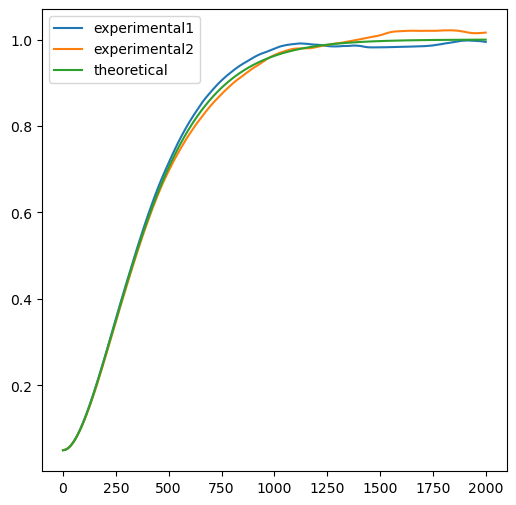

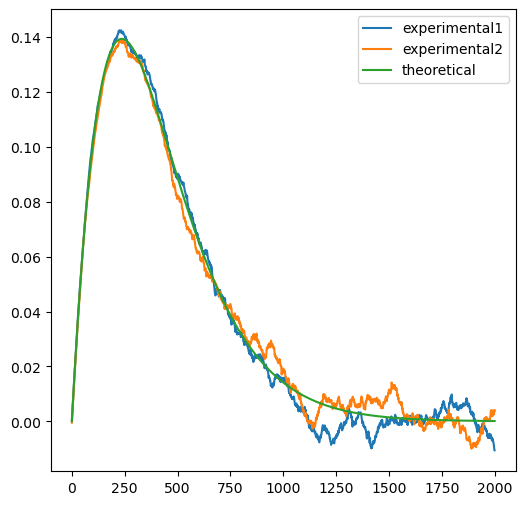

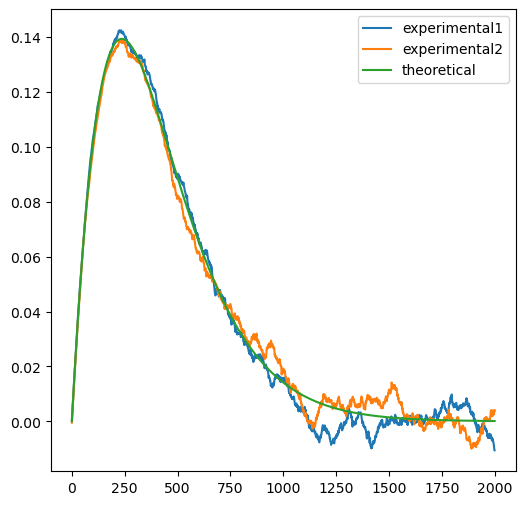

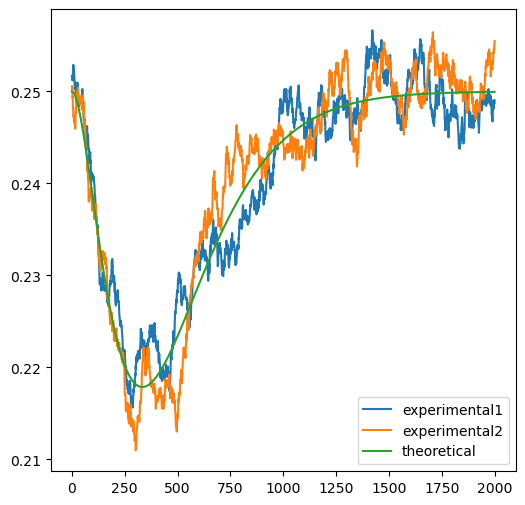

In [110]:
forward_covariances(jnp.array([0,0]), random.PRNGKey(7))

### rest

In [111]:
l_HSM = lambda t : jnp.sqrt( Sigma_xx(t)/(Sigma_xx(t)*Sigma_vv(t) - Sigma_xv(t)**2) )

L_Cholesky = lambda t : jnp.array([ [jnp.sqrt(Sigma_xx(t)) , jnp.zeros( t.shape ) ] ,\
                                  [ Sigma_xv(t)/jnp.sqrt(Sigma_xx(t)) , jnp.sqrt( (Sigma_xx(t)*Sigma_vv(t) - Sigma_xv(t)**2)/Sigma_xx(t) ) ]]).transpose((2,0,1))



In [112]:
# test 
batch = jnp.ones((batch_size,2,1))
t_batch = jnp.ones((batch_size,))
print(mu_global_HSM(t_batch, batch).shape)
print(L_Cholesky(t_batch).shape)
L_Cholesky(jnp.array([1.,0.5,0.3]))

ee (512, 1)
(512, 2)
(512, 2)
(512, 2, 2)
(512, 2, 2)


Array([[[9.9985701e-01, 0.0000000e+00],
        [1.2259457e-04, 4.9994746e-01]],

       [[9.8098063e-01, 0.0000000e+00],
        [1.4402821e-02, 4.9446359e-01]],

       [[8.9246458e-01, 0.0000000e+00],
        [7.3294789e-02, 4.7286606e-01]]], dtype=float32)

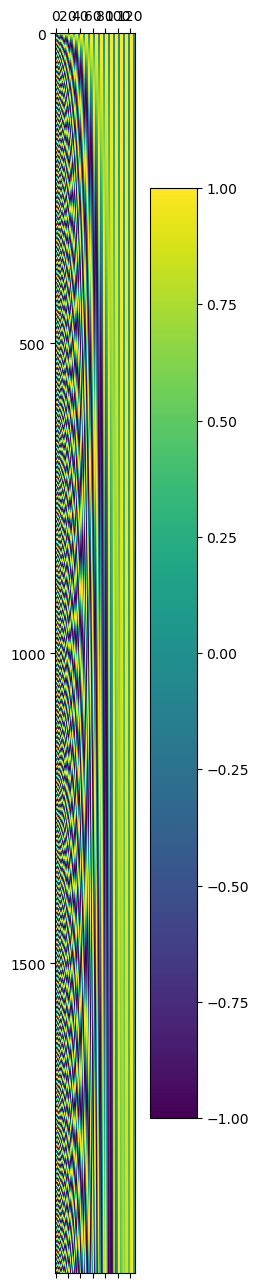

In [113]:
# test 
embedded = PositionalEncoding(jnp.arange(0,2000))

plt.matshow(embedded)
plt.colorbar()
plt.show()

In [114]:
class batch_MLP_bloc(nn.Module):                    # create a Flax Module dataclass
  out_dim: int
  hidden_dim : int = net_width
  
  @nn.compact
  def __call__(self, x):
    x = x.reshape((x.shape[0], -1))
    x = nn.Dense(net_width)(x)                 # create inline Flax Module submodules
    x = nn.relu(x)
    x = nn.Dense(net_width)(x)                 # create inline Flax Module submodules
    x = nn.relu(x)
    x = nn.Dense(net_width)(x)                 # create inline Flax Module submodules
    x = nn.relu(x)
    x = nn.Dense(self.out_dim)(x)       # shape inference
    return x


In [115]:

class epsilon_model_module(nn.Module) :
    @nn.compact
    def __call__(self, batch_positions, batch_velocities, time_embedding):
        """
        input :
        - batch_velocities : positions batch shape (batch_size, 2, 1)
        - batch_positions : positions batch shape (batch_size, 2, 1)
        - time_indices : shape (batch_size,) should be integers (float of int)
        output :
        - shape (batch_size,2,dimension)
        """
        
        time_embedding = batch_MLP_bloc(out_dim=net_width)( time_embedding )
        position_embedding = batch_MLP_bloc(out_dim=net_width)( batch_positions )
        velocity_embedding = batch_MLP_bloc(out_dim=net_width)( batch_velocities )
        
        global_embedding = jnp.concatenate( (time_embedding, position_embedding, velocity_embedding) , axis = 1)
        result = batch_MLP_bloc(hidden_dim = 2*net_width ,out_dim=2*net_width)( global_embedding )
        result = batch_MLP_bloc(hidden_dim = 2*net_width, out_dim=4)( global_embedding)
        result = result.reshape(batch_size,2,2)

        return(result)

def generateParameters(key):
    
    typical_batch_positions = jnp.empty((batch_size, 2,1))
    typical_batch_velocities = jnp.empty((batch_size, 2,1))
    typical_time_embedding = jnp.empty((batch_size,intermediate_embeding_time_dimension))
    key,subkey = random.split(key)
    parameters = epsilon_model_module().init(batch_positions = typical_batch_positions, batch_velocities = typical_batch_velocities, time_embedding= typical_time_embedding, rngs = subkey)
 
    return(key,parameters)

@jax.jit
def epsilon_model(parameters,batch_positions, batch_velocities, time_indices ):
    time_embedding = PositionalEncoding(time_indices)
    return epsilon_model_module().apply(parameters,batch_positions, batch_velocities, time_embedding)

In [116]:
# test 
key, parameters = generateParameters(key)

times = jnp.ones((batch_size,))
batch = random.normal(key, (batch_size,2,1) )
batch_velocities = random.normal(key, (batch_size,2,1) )
result = epsilon_model(parameters, batch, batch_velocities, times )
print(result.shape)

(512, 2, 2)


In [117]:


@jax.jit
def batch_loss(parameters, batch_positions, key) :
    """
    input :
    - parameters : a dictionary with three keys 'params_times', 'params_positions', 'params_vitesses', 'params_global' for the respectives MLP
    - batch_positions : positions batch shape (batch_size, 2, 1)
    """
    key, key2, key3, key4 = random.split(key,4)

    # sampling times
    time_indices = random.randint(key2, shape = (batch_size,), minval= 1, maxval= num_timesteps)
    real_time_batch = timeIndices2RealTime(time_indices )

    epsilon = random.normal(key3, shape = (batch_size,dimension, 2)) 

    batch_global = mu_global_HSM(real_time_batch, batch_positions) + (L_Cholesky( real_time_batch )[:,None,:,:]@epsilon[...,None])[:,:,:,0].transpose( (0,2,1) ) # shape (batch_size, 2,dim)
    batch_positions = batch_global[:,0,:]
    batch_velocities = batch_global[:,1,:]

    # TODO REMETRE LA VRAI LOSS DANS LE CAS GENERAL !! 
    # loss = jnp.mean( (epsilon.transpose((0,2,1)) - epsilon_model(parameters,batch_positions, batch_velocities, time_indices))**2 )
    loss = jnp.mean(( epsilon[:,:,1].squeeze() -  epsilon_model(parameters,batch_positions, batch_velocities, time_indices)[:,1,:].squeeze()  )**2 )
    return(loss)
    

In [118]:
# test 
real_time_batch = jnp.ones((batch_size,))

epsilon = random.normal(key, shape = (batch_size, 2, dimension))

batch_global = L_Cholesky(real_time_batch)@epsilon
print(batch_size)
print(L_Cholesky(real_time_batch).shape)
print(epsilon.shape)
print(batch_global.shape)

512
(512, 2, 2)
(512, 2, 2)
(512, 2, 2)


In [119]:
savingFileName = "second_order_parameters_v3" + ("_beta" + str(beta) + "_M" + str(M) + "_nu" + str(nu) + "_Gamma" + str(Gamma)).replace(".","-") +".npy"
def train_or_retrieve_model(key, savingFileName = savingFileName ) :

    if os.path.isfile(savingFileName) :
        with open(savingFileName, 'rb') as file:
            parameters = pickle.load(file)
    else :
        key, parameters = generateParameters(key)

        learning_rate = 0.002
        optimizer = optax.adam(learning_rate)
        opt_state = optimizer.init(parameters)

        loss_cache = []
        i = 0
        while i < num_training_iterations :

            for batch in train_dataloader :
                batch = batch[0]

                key = random.split(key, 1)[0]
                value, grads = jax.value_and_grad(batch_loss)(parameters, batch, key)
                loss_cache.append(value)
                if i%500 == 0 :
                    print( "step :", str(i), "   -   loss :", str(np.mean(loss_cache)))
                    loss_cache = [] 
                updates, opt_state = optimizer.update(grads, opt_state)
                parameters = optax.apply_updates(parameters, updates)
                i+=1

        with open(savingFileName, 'wb') as file:
            pickle.dump(parameters, file)
    return(parameters)

In [120]:
parameters = train_or_retrieve_model(key)
key, = random.split(key,1)

ee (512, 1)
(512, 2)
(512, 2)
step : 0    -   loss : 1.0594873
step : 500    -   loss : 0.1670799
step : 1000    -   loss : 0.15424268
step : 1500    -   loss : 0.15360044
step : 2000    -   loss : 0.15244584
step : 2500    -   loss : 0.15114395
step : 3000    -   loss : 0.15222879
step : 3500    -   loss : 0.15065844
step : 4000    -   loss : 0.15232177
step : 4500    -   loss : 0.1506264
step : 5000    -   loss : 0.15116507
step : 5500    -   loss : 0.15107498
step : 6000    -   loss : 0.15116012
step : 6500    -   loss : 0.15096651
step : 7000    -   loss : 0.15061478
step : 7500    -   loss : 0.15126365
step : 8000    -   loss : 0.14997381
step : 8500    -   loss : 0.14936149
step : 9000    -   loss : 0.15093417
step : 9500    -   loss : 0.15044679
step : 10000    -   loss : 0.15030271
step : 10500    -   loss : 0.1495794
step : 11000    -   loss : 0.15074643
step : 11500    -   loss : 0.15011634
step : 12000    -   loss : 0.14990783
step : 12500    -   loss : 0.15091224
step : 130

In [121]:
def L_Cholesky_inv_transpose(t_) :
    return jnp.array([ 
        [ 1./jnp.sqrt(Sigma_xx(t_)) ,  -Sigma_xv(t_)/jnp.sqrt((Sigma_vv(t_)*Sigma_xx(t_) - Sigma_xv(t_)**2)*Sigma_xx(t_))  ] ,
        [ jnp.zeros( t_.shape )     ,  jnp.sqrt(Sigma_xx(t_)/(Sigma_vv(t_)*Sigma_xx(t_) - Sigma_xv(t_)**2))                ]
        ]).transpose((2,0,1)) 

In [122]:
# test
t_ = jnp.array([10./num_timesteps])
print(Sigma_xx(t_))
print(Sigma_vv(t_))
print(Sigma_xv(t_))
print(-Sigma_xv(t_)/(jnp.sqrt(Sigma_vv(t_) - Sigma_xv(t_)**2/Sigma_xx(t_))*Sigma_xx(t_)))
print( jnp.sqrt(1./Sigma_vv(t_) - Sigma_xv(t_)**2/Sigma_xx(t_)) )
L_Cholesky_inv_transpose(t_)

[0.05083796]
[0.24979873]
[0.01382275]
[-0.5481548]
[1.9998661]


Array([[[ 4.435126 , -0.5481548],
        [ 0.       ,  2.0160291]]], dtype=float32)

In [123]:
def score(parameters,batch_positions, batch_velocities, time_indices) :
    """ 
    input :
    - TODO write
    output :
    - shape (batch_size,2,dim)
    """
    real_time_batch = timeIndices2RealTime(time_indices )
    # TODO remettre la formule initiale !!
    # return( -(L_Cholesky_inv_transpose(real_time_batch)[:,None,:,:]@epsilon_model(parameters,batch_positions, batch_velocities, time_indices).transpose((0,2,1))[:,:,:,None])[:,:,:,0].transpose((0,2,1)) )
    return( -l_HSM(real_time_batch)[:,None,None]*epsilon_model(parameters,batch_positions, batch_velocities, time_indices))

In [124]:
# test 
batch_positions = jnp.zeros((batch_size,2,1))
batch_velocities = jnp.zeros((batch_size,2,1))
time_indices = jnp.ones((batch_size,))

sco = score(parameters,batch_positions, batch_velocities, time_indices)
print(sco.shape)

(512, 2, 2)


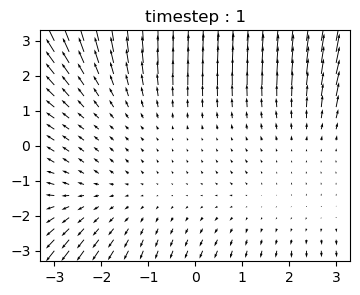

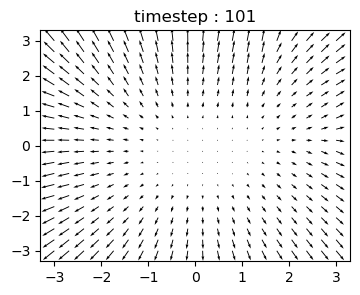

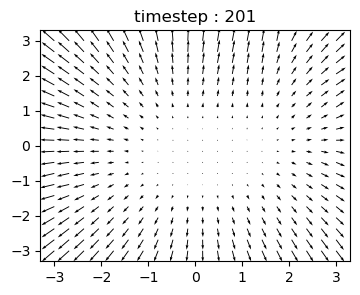

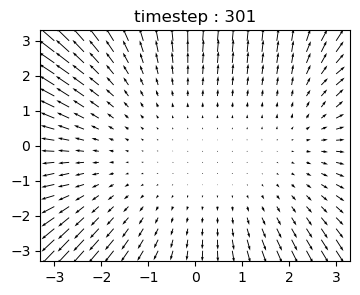

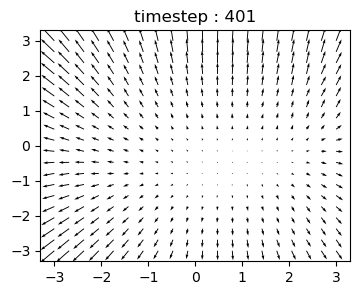

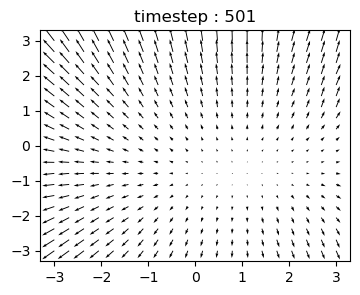

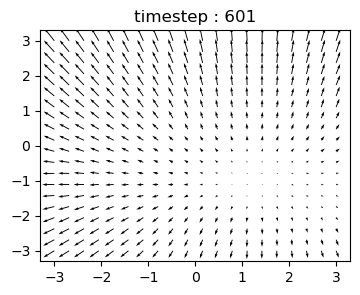

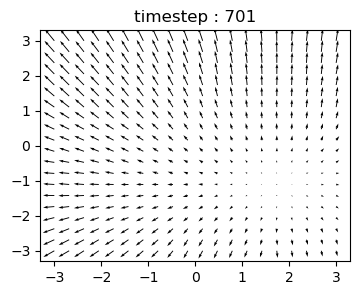

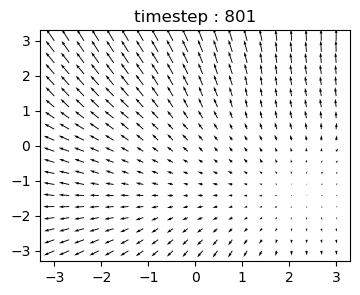

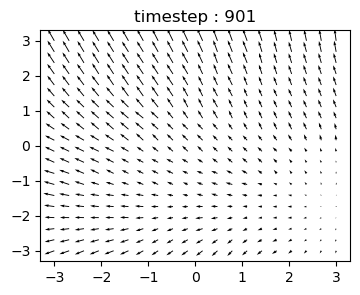

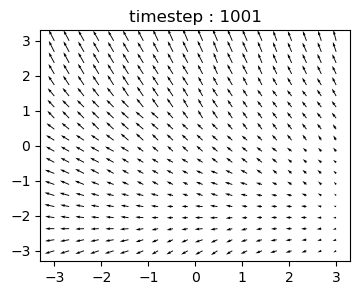

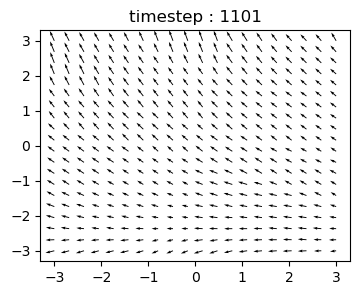

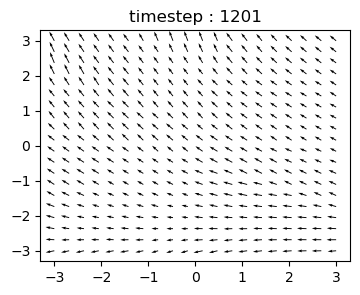

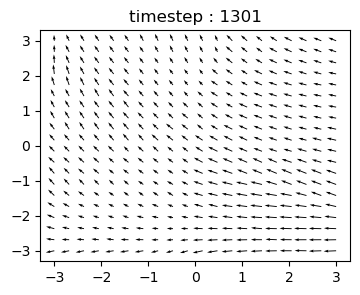

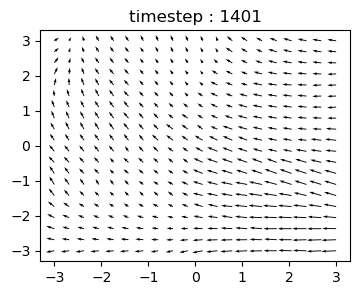

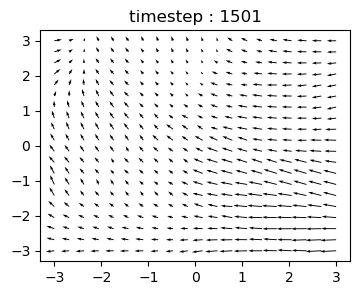

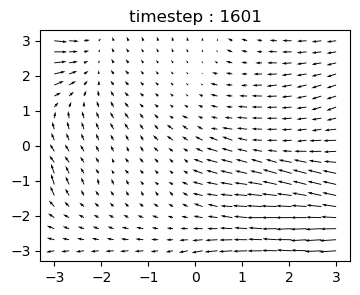

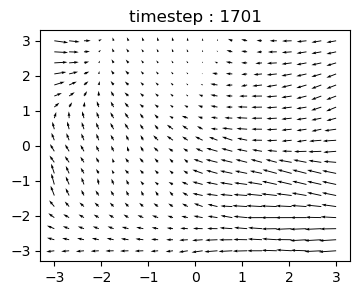

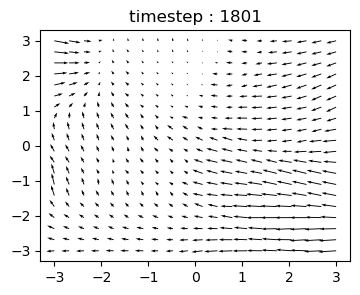

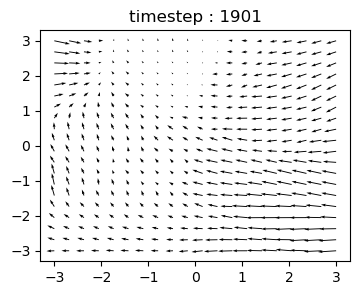

In [125]:
# test 
batch_velocities = jnp.zeros((batch_size, 2, 1))
# Batch_size must be superior to 400 for this test
for timestep in range(1,num_timesteps,100) :
    x,y = np.meshgrid(np.linspace(-3,3,20),np.linspace(-3,3,20))
    X = x.flatten()
    Y = y.flatten()
    batch = np.zeros((batch_size,2,1))
    batch[:400] = np.concatenate( [X[:,None],Y[:,None]], axis = 1)[...,None]
    time_indices = np.ones((batch_size,))*timestep
    scores = score(parameters, batch, batch_velocities, time_indices)[:400]
    u,v = scores[:,1,0], scores[:,1,1]

    # print( scores[:,0,0])
    plt.figure(figsize=(4,3))
    plt.quiver(x,y,u,v)
    plt.title( "timestep : " + str(timestep))
    plt.show()

In [126]:
# TEST 
# chercher le forward et les matrices de covariances pour un batch

In [127]:
@jax.jit
def deterministic_predictor(batch, i, step_size, parameters ) :

    """ 
    - batch : shape (batch_size, 2, dim, 1)
    - i : integer
    - step_size : shape (batch_size,)
    - parameters : dict of parameters for score(...)
    """

    batch_positions = batch[:,0,:] 
    batch_velocities = batch[:,1,:] 

    score_global = score(parameters, batch_positions, batch_velocities, time_indices[i+1])
    score_x = score_global[:,0,:,None]
    score_v = score_global[:,1,:,None]
    print("score_v",score_v.shape)
    print(score_x.shape)
    print("batch_positions" ,batch_positions.shape)
    print("batch_velocities",batch_velocities.shape)

    print("values of update", -( Gamma*batch_positions + 1.0/M*batch_velocities)*beta/2.*step_size[:,None,None] + \
                              jnp.sqrt(Gamma*beta*step_size[:,None,None])*0 + \
                              ( Gamma*batch_positions*0 + 1./2*Gamma*score_x )*beta*step_size[:,None,None] )

    

    batch_positions_updated = batch_positions + \
                              -( Gamma*batch_positions + 1.0/M*batch_velocities)*beta/2.*step_size[:,None,None] + \
                              jnp.sqrt(Gamma*beta*step_size[:,None,None])*0 + \
                              ( Gamma*batch_positions*0 + 1./2*Gamma*score_x )*beta*step_size[:,None,None]
    batch_velocities_updated = batch_velocities + \
                               (batch_positions - nu*batch_velocities)*beta/2.*step_size[:,None,None] + \
                               jnp.sqrt(M*nu*beta*step_size[:,None,None])*0 + \
                               ( nu*batch_velocities*0 + 1./2*M*nu*score_v )*beta*step_size[:,None,None]

    batch = jnp.concatenate( ( batch_positions_updated[:,None,:,:], batch_velocities_updated[:,None,:,:]), axis = 1)
    return(batch)

In [128]:
time_indices = jnp.array( list(range(num_timesteps))*batch_size).reshape(batch_size,num_timesteps).T

def generate_deterministic_batch(key, parameters, time_indices = time_indices) :
    
    """ 
    - key : PRNG key
    - time_indices : shape (num_timsteps, batch_size) , timsteps are ordered from smallest to biggest
    """

    key1, key = random.split(key)
    
    stepSize = timeSteps2stepSize(num_timesteps, batch_size)
    batch = random.normal(key1, shape = (batch_size, 2, 2,1))*jnp.array([1,M]).reshape((1,-1,1,1)) # prior distribution
    for i in range(num_timesteps- 2, 0, -1) :

        batch = deterministic_predictor( batch, i, stepSize[i], parameters )
        batch_positions = batch[:,0,:,:]
        ### test 
        if i%100 == 1 :
          plt.figure(figsize = (4,3))
          plt.scatter(batch_positions[:,0,0], batch_positions[:,1,0], s = 0.2, alpha = 0.7)
          plt.title("step : " + str(i))
          plt.show()
        ###

    return(batch)

score_v (512, 2, 1)
(512, 2, 1)
batch_positions (512, 2, 1)
batch_velocities (512, 2, 1)
values of update Traced<ShapedArray(float32[512,2,1])>with<DynamicJaxprTrace(level=1/0)>


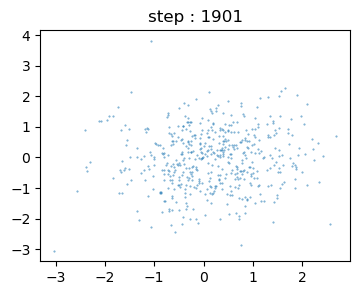

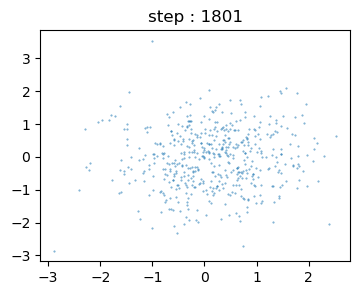

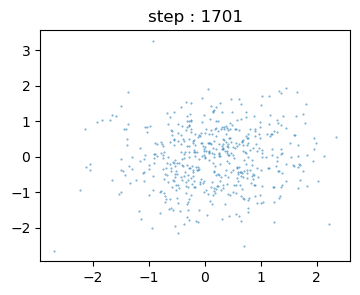

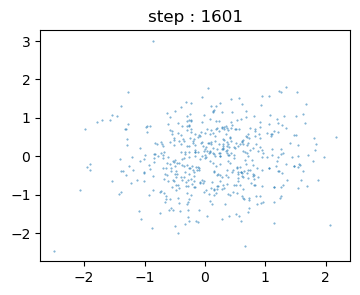

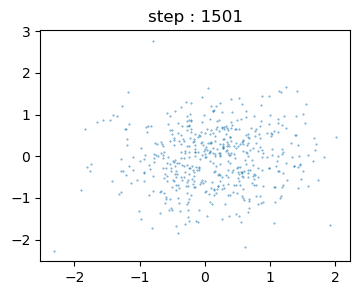

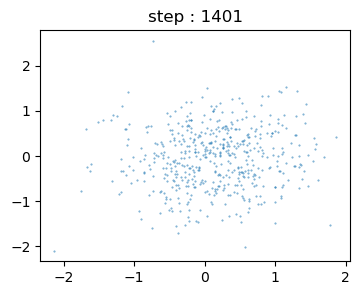

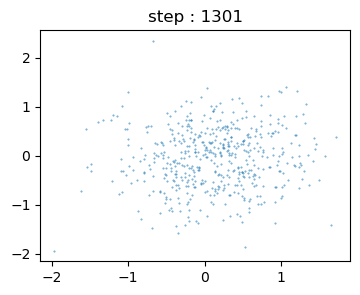

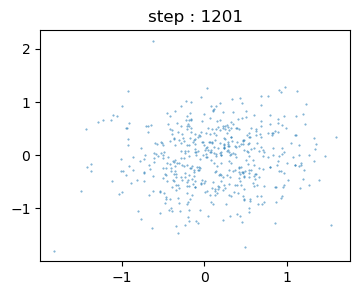

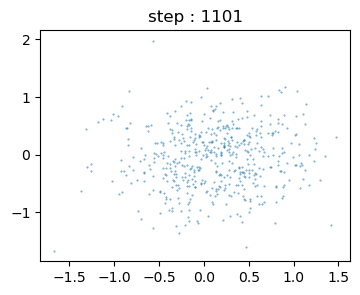

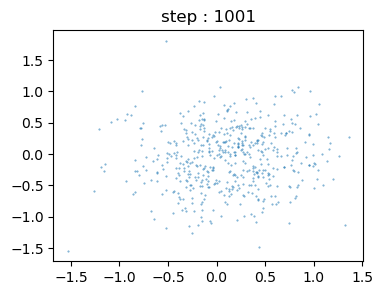

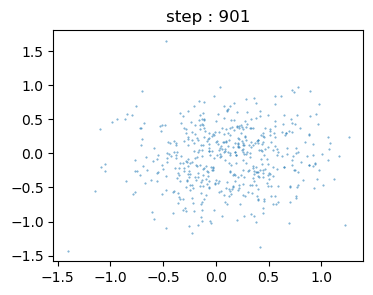

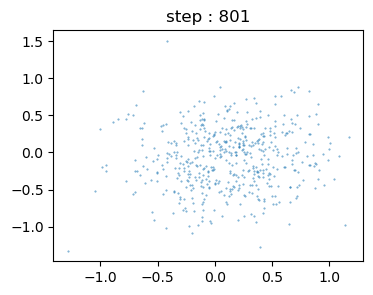

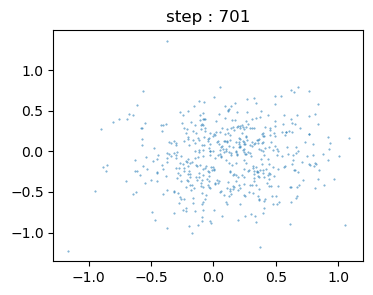

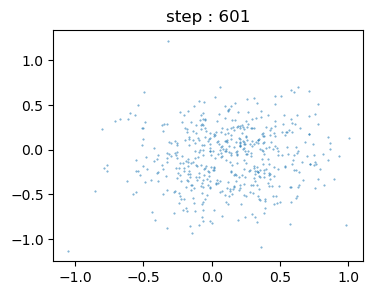

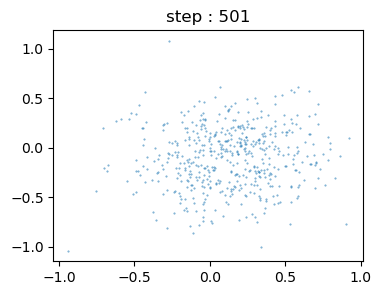

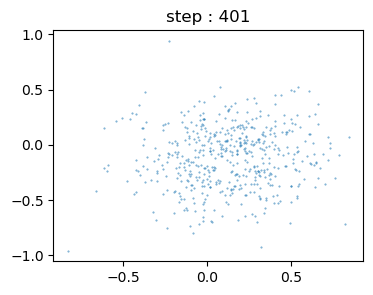

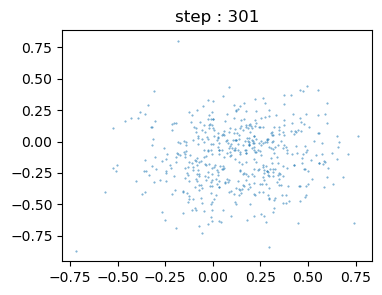

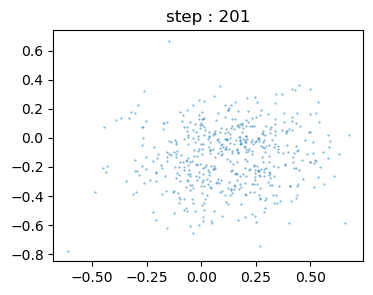

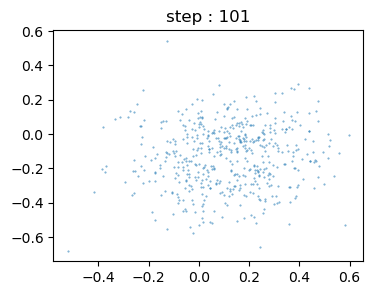

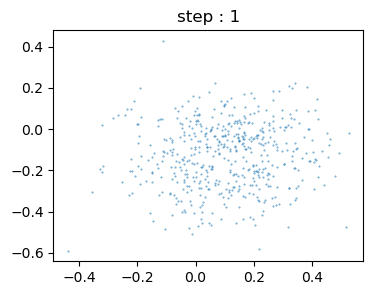

In [129]:
# with jax.disable_jit():
#     result = generate_deterministic_batch(key, parameters, time_indices = time_indices)

result = generate_deterministic_batch(key, parameters, time_indices = time_indices)


In [130]:
@jax.jit
def predictor(batch, i, step_size, parameters, key ) :
    """ 
    - batch : shape (batch_size, 2, dim, 1)
    - i : integer
    - step_size : shape (batch_size,)
    - parameters : dict of parameters for score(...)
    """
    key, subkey = random.split(key)
    
    batch_positions = batch[:,0,...] 
    batch_velocities = batch[:,1,...] 

    w = random.normal(subkey, shape = batch.shape)
    w_x = w[:,0,:,:]
    w_v = w[:,1,:,:]

    score_global = score(parameters, batch_positions, batch_velocities, time_indices[i+1])
    score_x = score_global[:,0,:,None]
    score_v = score_global[:,1,:,None]
    

    batch_positions_updated = batch_positions + \
                              -( Gamma*batch_positions + 1.0/M*batch_velocities)*beta/2.*step_size[:,None,None] + \
                              jnp.sqrt(Gamma*beta*step_size[:,None,None])*w_x + \
                              ( Gamma*batch_positions + Gamma*score_x )*beta*step_size[:,None,None]
    batch_velocities_updated = batch_velocities + \
                               (batch_positions - nu*batch_velocities)*beta/2.*step_size[:,None,None] + \
                               jnp.sqrt(M*nu*beta*step_size[:,None,None])*w_v + \
                               ( nu*batch_velocities + M*nu*score_v )*beta*step_size[:,None,None]

    batch = jnp.concatenate( ( batch_positions_updated[:,None,:,:], batch_velocities_updated[:,None,:,:]), axis = 1)
    return(key, batch)

In [131]:
time_indices = jnp.array( list(range(num_timesteps))*batch_size).reshape(batch_size,num_timesteps).T

def generate_batch(key, parameters, time_indices = time_indices) :
    
    """ 
    - key : PRNG key
    - time_indices : shape (num_timsteps, batch_size) , timsteps are ordered from smallest to biggest
    """

    key1, key = random.split(key)
    
    stepSize = timeSteps2stepSize(num_timesteps, batch_size)
    batch = random.normal(key1, shape = (batch_size, 2, 2,1))*jnp.array([1,M]).reshape((1,-1,1,1)) # prior distribution
    for i in range(num_timesteps- 2, 0, -1) :

        key, batch = predictor( batch, i, stepSize[i], parameters, key)
        batch_positions = batch[:,0,:,:]
        ### test 
        if i%100 == 1 :
          plt.figure(figsize = (4,3))
          plt.scatter(batch_positions[:,0,0], batch_positions[:,1,0], s = 0.2, alpha = 0.7)
          plt.title("step : " + str(i))
          plt.show()
        ###

    return(batch)

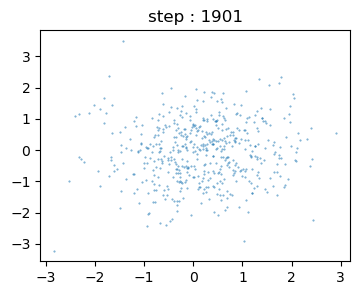

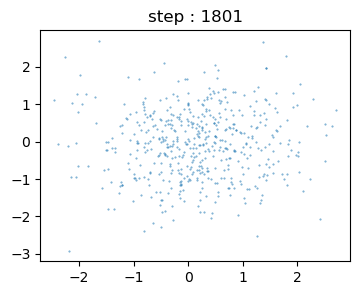

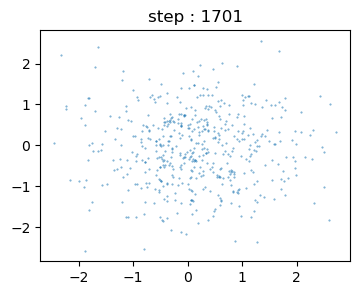

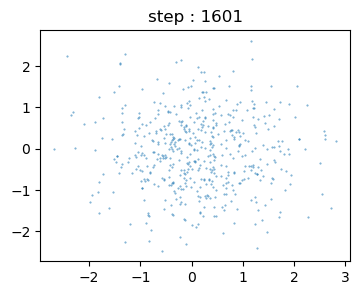

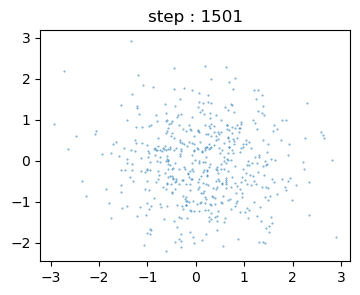

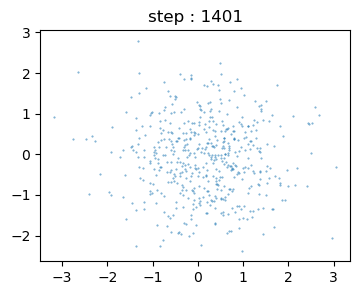

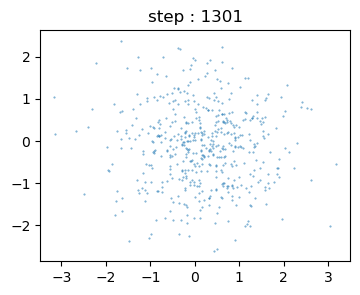

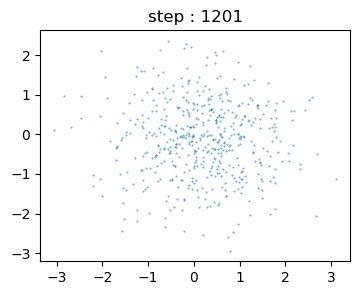

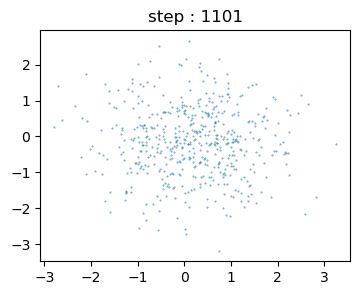

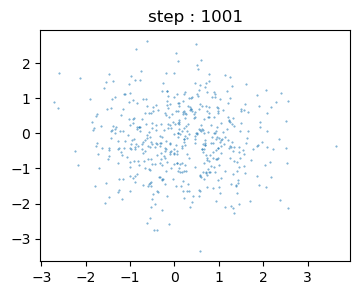

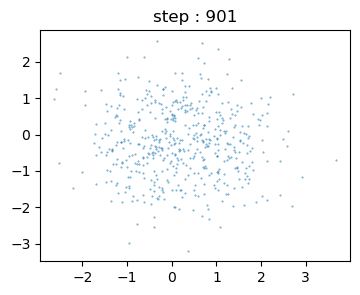

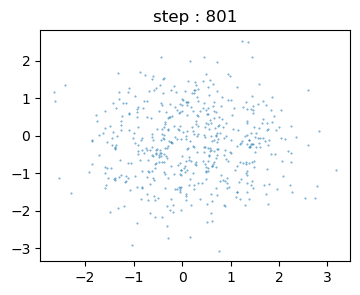

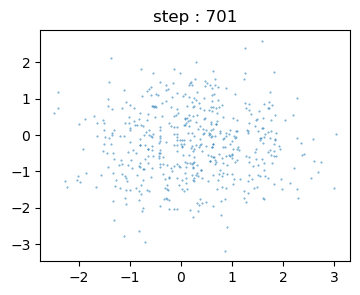

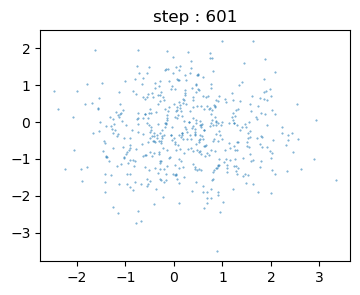

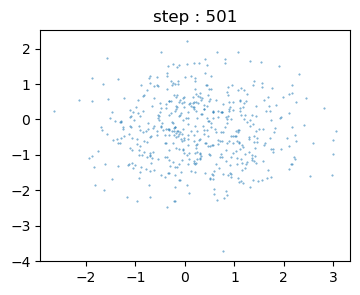

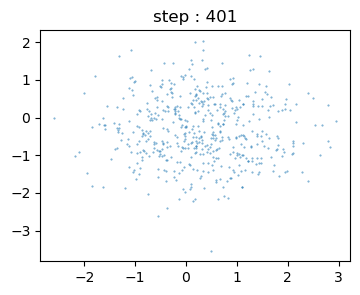

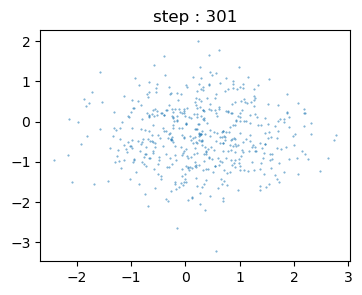

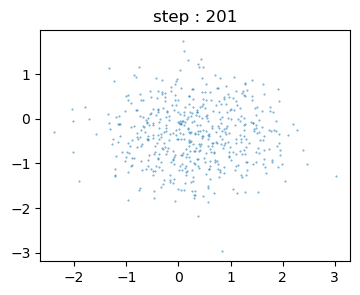

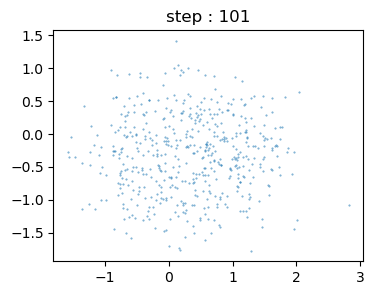

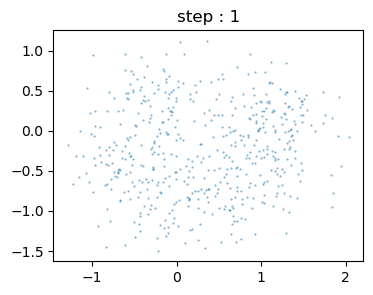

In [132]:
result = generate_batch(key, parameters, time_indices = time_indices)